# Hyperparameter tunning of p value when doing feature engineering

In [1]:
# For data exploration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
# For displaying results
import seaborn as sn
import os

In [2]:
pre_pv_list = np.linspace(0.90, 0.01, 20)
p_value_list = [np.round(x, 2) for x in pre_pv_list]

In [3]:
def rfc_train_evaluator(model_rfc, Xtrain, ytrain, Xtest, ytest) -> tuple:
    model_rfc.fit(Xtrain, ytrain)
    mean_accuracy = model_rfc.score(Xtest, ytest) * 100
    y_predicted = model_rfc.predict(Xtest)
    return (mean_accuracy, y_predicted)

In [4]:
default_rfc_model = RandomForestClassifier()

In [5]:
data_path = os.getcwd() + "/Data/"
results = list()
for p_value in p_value_list:
    filename = 'extracted_features_with_pv_' + str(p_value) + '.csv'
    dataset_df = pd.read_csv(data_path + filename)
    X_train, X_test, y_train, y_test = train_test_split(
        dataset_df.drop(['valid_or_not'], axis=1),
        dataset_df['valid_or_not'],
        test_size=0.2)
    smote = SMOTE(sampling_strategy='minority')
    X_sm, y_sm = smote.fit_resample(X_train, y_train) # data augmentation(dataset size increases)
    X_rtrain, X_rtest, y_rtrain, y_rtest = train_test_split(X_sm, y_sm, test_size=0.2)
    rfc_accuracy, rfc_predictions = rfc_train_evaluator(
        default_rfc_model, X_rtrain, y_rtrain, X_rtest, y_rtest)
    result = (rfc_accuracy, rfc_predictions, y_rtest)
    results.append(result)
    # rcm = confusion_matrix(y_rtest, rfc_predictions)

In [6]:
f1_scores_majority = list()
f1_scores_minority = list()
for result in results:
    f1_rscores = f1_score(result[2], result[1], average=None)
    f1_score_minority = np.round(f1_rscores[0], 2)
    f1_score_majority = np.round(f1_rscores[1], 2)
    f1_scores_minority.append(f1_score_minority)
    f1_scores_majority.append(f1_score_majority)

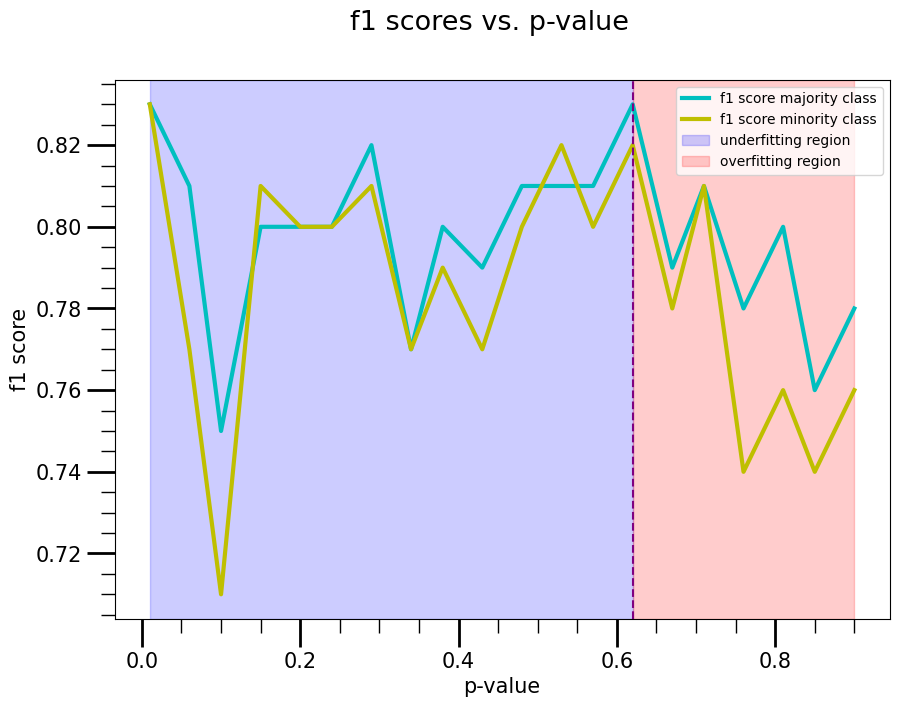

In [7]:
# START of settings
fs = 15  # fontsize
lw = 3  # linewidth
title = "f1 scores vs. p-value"
label_x = "p-value"
label_y = "f1 score"
fig = plt.figure(figsize=[10, 7])
major_tick_length = 20
major_tick_width = 2
minor_tick_length = 10
minor_tick_width = 1
# END of settings

fig.suptitle(title, fontsize=fs*1.3)
plt.plot(p_value_list, f1_scores_majority, linewidth=lw, color='c', label='f1 score majority class')
plt.plot(p_value_list, f1_scores_minority, linewidth=lw, color='y', label='f1 score minority class')
index_max = np.argmax(f1_scores_majority)
plt.axvline(x=p_value_list[index_max], color='purple', linestyle='--')
plt.axvspan(min(p_value_list), p_value_list[index_max], alpha=0.2, color='blue', label='underfitting region')
plt.axvspan(p_value_list[index_max], max(p_value_list), alpha=0.2, color='red', label='overfitting region')
plt.xlabel(label_x, fontsize=fs)
plt.ylabel(label_y, fontsize=fs)
plt.tick_params("both", length=major_tick_length, width=major_tick_width, which="major", labelsize=fs)
plt.tick_params("both", length=minor_tick_length, width=minor_tick_width, which="minor", labelsize=fs)
plt.minorticks_on()
plt.legend()
plt.show()

- To complement our analysis could be interesting the ratio of number of features with the total number of datapoints as function of the p value.

$$R_{fd} = \frac{N_f}{N_d}$$
- where:
    - $R_{fd}$: is the features-datapoints ratio
    - $N_f$: is the number of features
    - $N_d$: is the number of features

In [8]:
dataset_size = len(dataset_df)
dataset_size_augmented = 1080 * 2
train_dataset_size = int(dataset_size_augmented * 0.8)
test_dataset_size = int(dataset_size_augmented * 0.2)
features_size = [3426, 3315, 3223, 3086, 2962, 2856, 2748, 2606, 2510, 2360,
                 2189, 1956, 1781, 1590, 1394, 1259, 1053, 807, 536, 88]
ratio_list = [x / train_dataset_size for x in features_size]

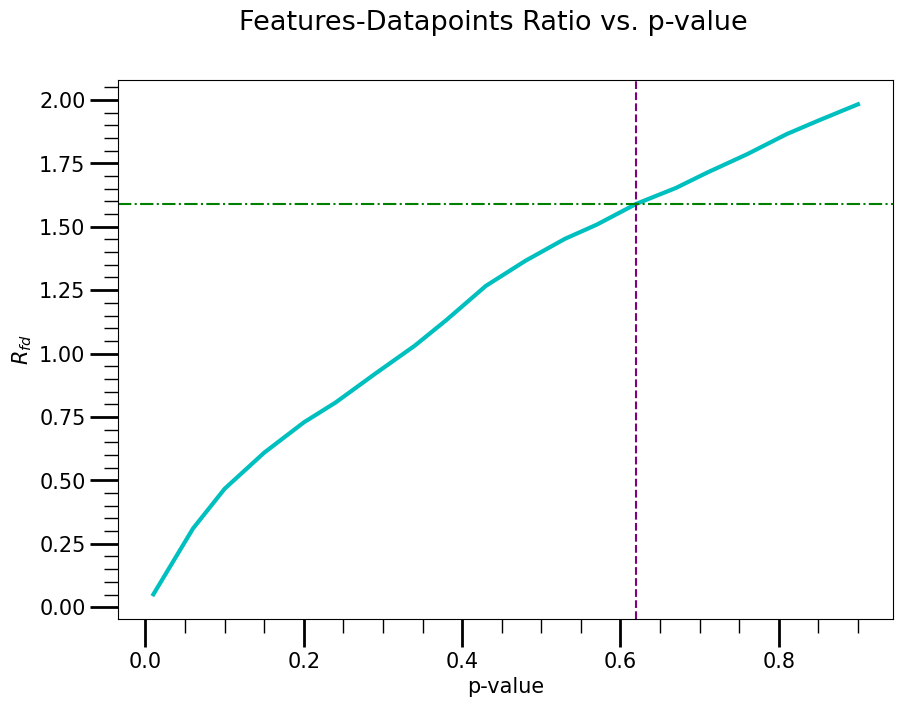

In [9]:
# START of settings
fs = 15  # fontsize
lw = 3  # linewidth
title = "Features-Datapoints Ratio vs. p-value"
label_x = "p-value"
label_y = "$R_{fd}$"
fig = plt.figure(figsize=[10, 7])
major_tick_length = 20
major_tick_width = 2
minor_tick_length = 10
minor_tick_width = 1
# END of settings

fig.suptitle(title, fontsize=fs*1.3)
plt.plot(p_value_list, ratio_list, linewidth=lw, color='c')
index_max = np.argmax(f1_scores_majority)
plt.axvline(x=p_value_list[index_max], color='purple', linestyle='--')
plt.axhline(y=ratio_list[index_max], color='green', linestyle='-.')
plt.xlabel(label_x, fontsize=fs)
plt.ylabel(label_y, fontsize=fs)
plt.tick_params("both", length=major_tick_length, width=major_tick_width, which="major", labelsize=fs)
plt.tick_params("both", length=minor_tick_length, width=minor_tick_width, which="minor", labelsize=fs)
plt.minorticks_on()
plt.show()

In [10]:
p_value_list[index_max]

0.62

## Conclusions
- We conclude that the optimal p-value when using the Random Forest Classifier with default hyperparameters and data augmentation with minority strategy is $p-value=0.48$.
- We believe that this particular $p-value$ divides the feature engineering process in two regions. The first region with a for $p-value<0.48$ corresponds to the **underfitting region** where we have too little features to make good predictions (we see that the f1-score goes to zero as $p-value$ approaches zero. The second region is given by $p-value>0.48$ which corresponds to the **overfitting region** where we on the contrary have too many features and the f1 score on the test set decreases similarly to the underfitting region.
- Remarkably if we analyse the Features-Datapoints ratio we observer that the $p-value$ that gives the best f1 score corresponds to the feature engineering where the $R_{fd}\approx1.3$. This $p-value=0.48$ should be the chosen value in our consecutive analysis when dealing with hyperparameter optimizations for Random Forest Classifier and other Machine Learning Models.